In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import akshare as ak
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from database.downloader.downloader_base import DownloaderBase
import database.database_config as db_config

pd.options.display.max_rows=None
pd.options.display.max_columns=None

!python --version

Python 3.8.10


In [2]:
import tensorflow as tf

# 只使用CPU进行训练
tf.config.set_visible_devices([], 'GPU')

# 打印Tensorflow版本
print(f"Tensorflow Version: {tf.__version__}")

# 检查是否有可用的GPU设备
if tf.test.is_built_with_cuda():
    print("TensorFlow GPU version is installed")
else:
    print("TensorFlow CPU version is installed")

# 检查TensorFlow是否能够访问GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices available:", gpus)
else:
    print("No GPU devices found. Running on CPU.")

# !nvidia-smi

2024-05-14 08:39:01.939351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 08:39:02.844115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow Version: 2.13.1
TensorFlow GPU version is installed
GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 绘图相关函数
def plot_series_dist(series):
    data = series
    plt.figure(figsize=(5,5))
    # 使用matplotlib画直方图
    plt.hist(data, bins=60, edgecolor='k', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data')
    plt.show()

def plot_metrics(history):
  metrics = ['loss', 'mean_absolute_error']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.ylim([0, plt.ylim()[1]])
    plt.legend()

def plot_cm(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="g", cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

In [4]:
class PreProcessing:
    def __init__(self, db_downloader:DownloaderBase) -> None:
        self.db_downloader = db_downloader

    def _build_reg_label(self, stock_dataframe, N=15):
        stock_df = stock_dataframe.copy()
        # 计算未来N日内的最高收益率
        stock_df['max_return'] = stock_df['close'].rolling(window=N).max().shift(-N) / stock_df['close'] - 1
        # 计算未来N日内的最低收益率
        stock_df['min_return'] = stock_df['close'].rolling(window=N).min().shift(-N) / stock_df['close'] - 1
        # 计算未来N日内的收益率和（期望最高收益率越高越好，最低收益率也越高越好，由于最低收益率是负数，因此使用最高+最低来作为综合收益指标）
        stock_df['return_sum'] = stock_df['max_return'] + stock_df['min_return']
        # 计算未来N日收益率的波动情况
        stock_df['volatility'] = stock_df['close'].pct_change().rolling(window=N).std().shift(-N)
        # 使用收益率 / 波动作为夏普label（期望收益率大的同时，波动更小）
        stock_df['label'] = stock_df['return_sum'] / stock_df['volatility']
        # 过滤第二天涨停股票
        stock_df = stock_df[stock_df['high'].shift(-1) != stock_df['low'].shift(-1)]
        return stock_df[['datetime', 'label']]

    def _process_one_stock(self, stock_code, start_date, end_date):
        stock_base = self.db_downloader._download_stock_base_info(stock_code) # 获取基础代码
        stock_individual = self.db_downloader._download_stock_individual_info(stock_code) # 获取profile信息
        stock_history = self.db_downloader._download_stock_history_info(stock_code, start_date, end_date) # 获取个股历史行情
        stock_indicator = self.db_downloader._download_stock_indicator_info(stock_code, start_date, end_date) # 获取指标数据
        stock_factor_date = self.db_downloader._download_stock_factor_date_info() # 获取日期特征
        stock_factor_qlib = self.db_downloader._download_stock_factor_qlib_info(stock_code, start_date, end_date) # 获取量价特征
        stock_label = self._build_reg_label(stock_history) # 构建Label
        stock_df = stock_base.merge(stock_individual, on=['stock_code']).merge(stock_history, on=['stock_code']).merge(stock_indicator, on=['stock_code', 'datetime']).merge(stock_label, on=['datetime']).merge(stock_factor_date, on=['datetime']).merge(stock_factor_qlib, on=['stock_code', 'datetime']) # 整合数据
        stock_df = stock_base \
            .merge(stock_individual, on=['stock_code', 'stock_name']) \
            .merge(stock_history, on=['stock_code']) \
            .merge(stock_indicator, on=['stock_code', 'datetime']) \
            .merge(stock_label, on=['datetime']) \
            .merge(stock_factor_date, on=['datetime']) \
            .merge(stock_factor_qlib, on=['stock_code', 'datetime']) # 整合数据
        stock_df = stock_df.dropna()
        return stock_df
    
    def _process_all_stock(self, benchmark, start_date, end_date):
        stock_code_list = list(ak.index_stock_cons(benchmark)['品种代码'].unique()) # 获取指数成分股列表
        stock_df_list = []
        for stock_code in tqdm(stock_code_list, desc=f'Process: {benchmark} ...'):
            stock_df = self._process_one_stock(stock_code, start_date, end_date)
            if not stock_df.empty:
                stock_df_list.append(stock_df)
        return pd.concat(stock_df_list)

In [5]:
def get_rolling_data_period(backtest_start_date, backtest_duration=5, train_period=6, val_period=0.5, test_period=0.5):
    """
    Args:
        backtest_start_date (_type_): _description_
        backtest_duration (int, optional): _description_. Defaults to 5.
        train_period (int, optional): _description_. Defaults to 6.
        val_period (float, optional): _description_. Defaults to 0.5.
        test_period (float, optional): _description_. Defaults to 0.5.
    Returns:
        result: _description_
    """
    backtest_start_date = datetime.strptime(backtest_start_date, '%Y%m%d')
    backtest_end_date = backtest_start_date + relativedelta(years=backtest_duration) # 回测5年数据
    train_period = relativedelta(years=train_period) # 使用6年的训练数据
    val_period = relativedelta(months=(12 * val_period)) # 使用半年的验证数据
    test_period = relativedelta(months=(12 * test_period)) # 使用半年的测试数据(半年模型一更新)

    result = []
    rolling_flag = True
    bench_date = backtest_start_date
    while rolling_flag:
        if bench_date < backtest_end_date:
            test_start, test_end = bench_date, (bench_date + test_period - relativedelta(days=1))
            val_start, val_end = (test_start - relativedelta(days=1) - val_period), (test_start - relativedelta(days=1))
            train_start, train_end =(val_start - relativedelta(days=1) - train_period), (val_start - relativedelta(days=1))
            result.append({
                "train": [train_start.strftime("%Y%m%d"), train_end.strftime("%Y%m%d")],
                "val": [val_start.strftime("%Y%m%d"), val_end.strftime("%Y%m%d")],
                "test": [test_start.strftime("%Y%m%d"), test_end.strftime("%Y%m%d")]
            })
            bench_date += test_period
        else:
            rolling_flag = False 
    return result

In [6]:
def extract_train_val_data(df, train_start_date, train_end_date, val_start_date, val_end_date, test_start_date, test_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date = pd.to_datetime(train_end_date)
    val_start_date = pd.to_datetime(val_start_date)
    val_end_date = pd.to_datetime(val_end_date)
    test_start_date = pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)

    train_data = df[(pd.to_datetime(df['datetime']) >= train_start_date) & (pd.to_datetime(df['datetime']) <= train_end_date)]
    val_data = df[(pd.to_datetime(df['datetime']) >= val_start_date) & (pd.to_datetime(df['datetime']) <= val_end_date)]
    test_data = df[(pd.to_datetime(df['datetime']) >= test_start_date) & (pd.to_datetime(df['datetime']) <= test_end_date)]

    print(f"train_data_size: {train_data.shape}")
    print(f"validation_data_size: {val_data.shape}")
    print(f"test_data_size: {test_data.shape}")
    return train_data, val_data, test_data

def df_to_dataset(dataframe, feature_cols, label_cols, shuffle=False, batch_size=32):
    features = dataframe[feature_cols]
    labels = dataframe[label_cols]
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(features), 10000), seed=1024)
    ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


class QuantileClipTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        
    def fit(self, X, y=None):
        # 计算给定分位数的分界值
        self.lower_bound_ = np.nanquantile(X, self.lower_quantile, axis=0)
        self.upper_bound_ = np.nanquantile(X, self.upper_quantile, axis=0)
        return self
    
    def transform(self, X, y=None):
        # 对整个数组应用剪辑操作
        return np.clip(X, self.lower_bound_, self.upper_bound_)

    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, y).transform(X)

In [8]:
# 数据库初始化
db_conn = sqlite3.connect('../database/hh_quant.db')
db_downloader = DownloaderBase(db_conn, db_config)
proprocessor = PreProcessing(db_downloader=db_downloader)

# 相关配置
rolling_flag = False
benchmark = '000905'
feature_config = {
    "target_features": ['label'],
    "numeric_features": ['turnover_rate', 'pe_ttm', 'ps_ttm', 'pcf_ncf_ttm', 'pb_mrq', 'KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNTN60', 'CNTD5', 'CNTD10', 'CNTD20', 'CNTD30', 'CNTD60', 'SUMP5', 'SUMP10', 'SUMP20', 'SUMP30', 'SUMP60', 'SUMN5', 'SUMN10', 'SUMN20', 'SUMN30', 'SUMN60', 'SUMD5', 'SUMD10', 'SUMD20', 'SUMD30', 'SUMD60', 'VMA5', 'VMA10', 'VMA20', 'VMA30', 'VMA60', 'VSTD5', 'VSTD10', 'VSTD20', 'VSTD30', 'VSTD60', 'WVMA5', 'WVMA10', 'WVMA20', 'WVMA30', 'WVMA60', 'VSUMP5', 'VSUMP10', 'VSUMP20', 'VSUMP30', 'VSUMP60', 'VSUMN5', 'VSUMN10', 'VSUMN20', 'VSUMN30', 'VSUMN60', 'VSUMD5', 'VSUMD10', 'VSUMD20', 'VSUMD30', 'VSUMD60'],
    "integer_categorical_features": ['month'],
    "string_categorical_features": ['industry', 'season'],
}
batch_size = 1024

# 是否开启滚动训练&回测
if rolling_flag:
    print("开启滚动回测...")
    backtest_period = get_rolling_data_period(
        backtest_start_date='20200101', # 回测开始日期
        backtest_duration=4, # 一共回测多久的数据（单位：年）
        train_period=6, # 使用过去多久的时间进行训练（单位：年）
        val_period=1, # 验证数据周期（单位：年）
        test_period=1, # 测试数据周期（单位：年）
    )
else:
    print("关闭滚动回测...")
    backtest_period = [
        {
            'train': ['20090101', '20161231'], # 8年训练
            'val': ['20170101', '20181231'], # 2年验证
            'test': ['20190101', '20231231'] # 5年预测
        }
    ]

backtest_period

关闭滚动回测...


[{'train': ['20090101', '20161231'],
  'val': ['20170101', '20181231'],
  'test': ['20190101', '20231231']}]

In [9]:
# df = proprocessor._process_all_stock('000016', '20000101', '20050101')

In [10]:
date_period_params = backtest_period[0]
print(date_period_params)
train_start_date, train_end_date = date_period_params['train']
val_start_date, val_end_date = date_period_params['val']
test_start_date, test_end_date = date_period_params['test']
# 获取全区间数据
print("开始加载原始数据...")
df = proprocessor._process_all_stock(benchmark=benchmark, start_date=train_start_date, end_date=test_end_date)
# 抽取训练验证数据
print("开始拆分训练、验证、测试集合...")
train_data, val_data, test_data = extract_train_val_data(df, *[train_start_date, train_end_date, val_start_date, val_end_date, test_start_date, test_end_date])
# 从data中抽取相关特征数据
print("开始抽取特征数据...")
feature_columns = feature_config.get('numeric_features', []) + feature_config.get('integer_categorical_features', []) + feature_config.get('string_categorical_features', [])
label_columns = feature_config.get('target_features', [])
full_feature_columns = feature_columns + label_columns
train_df, val_df, test_df = train_data[full_feature_columns], val_data[full_feature_columns], test_data[full_feature_columns]
# 对相关特征进行特征工程
print("开始对特征进行预处理...")
feature_preprocess_pipeline = Pipeline(steps=[
    ('robust_scaler', RobustScaler()),
    ('minmax_scaler', MinMaxScaler()),
])
preprocess_feature_columns = feature_config.get('numeric_features', [])
train_df[preprocess_feature_columns] = feature_preprocess_pipeline.fit_transform(train_df[preprocess_feature_columns])
val_df[preprocess_feature_columns] = feature_preprocess_pipeline.transform(val_df[preprocess_feature_columns])
test_df[preprocess_feature_columns] = feature_preprocess_pipeline.transform(test_df[preprocess_feature_columns])

print("开始对标签进行预处理...")
label_preprocess_pipeline = Pipeline(steps=[
    ('quantile_clipper', QuantileClipTransformer()),
    ('robust_scaler', RobustScaler()),
    ('minmax_scaler', MinMaxScaler()),
])
preprocess_target_columns = feature_config.get('target_features', [])
train_df[preprocess_target_columns] = label_preprocess_pipeline.fit_transform(train_df[preprocess_target_columns])
val_df[preprocess_target_columns] = label_preprocess_pipeline.transform(val_df[preprocess_target_columns])
test_df[preprocess_target_columns] = label_preprocess_pipeline.transform(test_df[preprocess_target_columns])

{'train': ['20090101', '20161231'], 'val': ['20170101', '20181231'], 'test': ['20190101', '20231231']}
开始加载原始数据...


Process: 000905 ...: 100%|██████████| 430/430 [01:19<00:00,  5.39it/s]


开始拆分训练、验证、测试集合...
train_data_size: (304728, 207)
validation_data_size: (146037, 207)
test_data_size: (464977, 207)
开始抽取特征数据...
开始对特征进行预处理...
开始对标签进行预处理...


In [11]:
# 转换为tensorflow所使用的dataset
print("开始将DataFrame转换为DataSet...")
train_ds = df_to_dataset(train_df, feature_columns, label_columns, shuffle=True, batch_size=batch_size)
val_ds = df_to_dataset(val_df, feature_columns, label_columns, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_df, feature_columns, label_columns, shuffle=False, batch_size=batch_size)  

开始将DataFrame转换为DataSet...


In [12]:
# 准备模型训练
print("开始模型初始化 & 训练...")
from models.single_task.model_moe import QuantModel
model_config = {
        "seed": 1024,
        "feature_use_embedding": False,
        "feature_embedding_dims": 4,
        "numeric_features_with_boundaries": {k: pd.qcut(train_df[k], q=20, retbins=True, duplicates='drop')[1].tolist() for k in feature_config.get('numeric_features', [])},
        "integer_categorical_features_with_vocab": {k: list(train_df[k].unique()) for k in feature_config.get('integer_categorical_features', [])},
        "string_categorical_features_with_vocab": {k: list(train_df[k].unique()) for k in feature_config.get('string_categorical_features', [])},
    }
model = QuantModel(config=model_config)

initial_learning_rate = 5e-4

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=5 * (len(train_df) // batch_size), # 每5个batch进行一次调整
#     decay_rate=0.9,
#     staircase=True)
model.compile(
    # optimizer=tf.keras.optimizers.Adam(lr_schedule),
    optimizer=tf.keras.optimizers.Adam(initial_learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
    # loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[
        tf.keras.metrics.MeanSquaredError()
    ])

EPOCHS = 500

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

baseline_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks = [early_stopping],
)

开始模型初始化 & 训练...
Epoch 1/500


2024-05-14 09:17:05.848035: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14db7835fa20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-14 09:17:05.848153: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-14 09:17:05.892104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 09:17:06.128093: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


298/298 [==============================] - 64s 194ms/step - loss: 72.0092 - mean_squared_error: 72.0092 - val_loss: 2.0319 - val_mean_squared_error: 2.0319
Epoch 2/500
298/298 [==============================] - 29s 98ms/step - loss: 57.7623 - mean_squared_error: 57.7623 - val_loss: 1.4017 - val_mean_squared_error: 1.4017
Epoch 3/500
298/298 [==============================] - 29s 98ms/step - loss: 41.6487 - mean_squared_error: 41.6487 - val_loss: 1.4272 - val_mean_squared_error: 1.4272
Epoch 4/500
298/298 [==============================] - 26s 87ms/step - loss: 28.7678 - mean_squared_error: 28.7678 - val_loss: 0.9979 - val_mean_squared_error: 0.9979
Epoch 5/500
298/298 [==============================] - 28s 93ms/step - loss: 19.5230 - mean_squared_error: 19.5230 - val_loss: 0.8716 - val_mean_squared_error: 0.8716
Epoch 6/500
298/298 [==============================] - 28s 93ms/step - loss: 12.7065 - mean_squared_error: 12.7065 - val_loss: 0.7288 - val_mean_squared_error: 0.7288
Epoch 7/5

In [13]:
# model.save(f'./tf_models/{benchmark}/')

In [14]:
# plot_series_dist(test_df['label'])

In [15]:
# 输出回测预测
print("开始保存回测预测结果...")
model_pred_result = model.predict(test_ds)
output_df = test_data[['stock_code', 'stock_name', 'datetime']]
output_df['label'] = test_df['label']
output_df['label_pred'] = model_pred_result
output_df.to_pickle(f'../../Offline/backtest/backtest_data/test/{benchmark}_{test_start_date}_回归任务.pkl') 

开始保存回测预测结果...
455/455 [==============================] - 50s 108ms/step


6.715823e+16

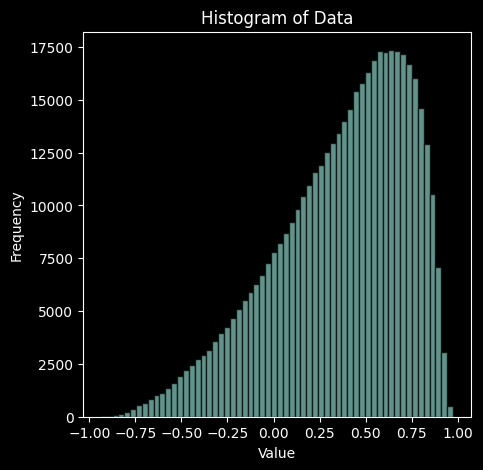

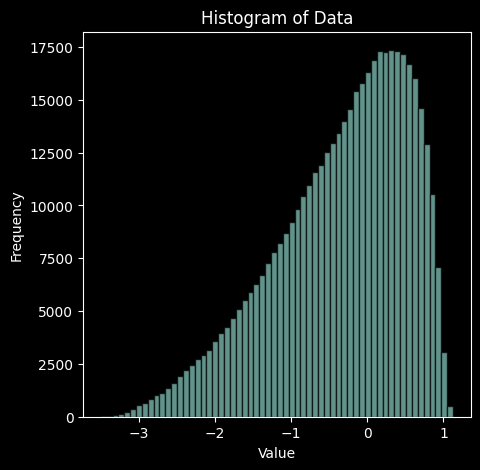

In [26]:
feas = 'CORR30'
plot_series_dist(test_data[feas])
plot_series_dist(test_df[feas])